In [2]:
"""
This script is used to loop over a collection of .pgm spectrograph data from MISS-1 and detect continuum emission events.
In general, this script is based on two assumptions:
    1) The three auroral emission lines are distinct peaks in the column-wise mean spectrum when auroral events are observed in (relatively) clear skies
    2) Auroral continuum emission is observed as a spectral enhancement in the entire 400-700 nm wavelength range and hence can be registered as a 
        distinct peak in the row-wise mean spectrum.

NOTE:
- The scipy peak finding function parameters (prominence and width) are not optimized!!
- The current parameters are based on a comparison between known continuum, 'normal' aurora and clear sky events.
- Weak continuum events are possibly not detected. 

Filtering out false positives, such as sunlit clouds, is done in the MISS-1 post-detection analysis script.

The first two defined functions are from the KHO-MISS/SpectralCalibration/miss_read_spectral.py script.

Created on May 9 2025

@author: Tim Hulsen
"""

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

In [3]:
"""
Reads a MISS-image and corrects the "smiley" spectral image into
a nice rectangular image.

Outputs a matrix with the vertical axis being a proxy for the scan
angle (no calibration yet). The horizontal axis is wavelength from
400nm to 700nm

For each scan angle (image row), the known emission lines are used
to first construct a mapping between wavelengths and pixel columns.
Then the intensities for wavelengths between 400..700nm at 1nm steps
are interpolated from the image.

NOTE:
    - the wavelength calibration is based on only three points, or
      the blue, green and red emission lines
    - the "scan angle" is not calibrated at all!


Created on Fri May 10 13:30:25 2024

@author: MikkoS
"""

# A user called Felix wrote a nice short reading routine for ASCII PGM-files
# https://stackoverflow.com/questions/46944048/how-to-read-pgm-p2-image-in-python
#
# The commonly used PIL for image reading in python seems to have trouble
# handling the comments in PGM-files, even though the comments are part
# of the "standard" for PNM-format.

def readpgm(name):
    with open(name) as f:
        lines = f.readlines()

    # Ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    # Makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2', 'File not an ASCII PGM-file'

    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    data=(np.array(data[3:]),(data[1],data[0]),data[2])
    return np.reshape(data[0],data[1])

In [4]:
def read_miss_spectral(filename):
    im=readpgm(filename)


    # Estimate the background level from an image corner and
    # remove the pixel offset
    bg_estimate=np.mean(im[0:29,0:29])
    im=np.maximum(im-bg_estimate,0).transpose()


    # From quick calibration using auroral emission lines,
    # see plot_misspeaks.m in the Matlab source code

    bluepoly=np.poly1d([-0.000401186790506, 0.118021155830754,
                        86.670020639834831]);
    redpoly=np.poly1d([-0.0003147574819, 0.1045665634675,
                            656.6050051599582]);
    greenpoly=np.poly1d([-0.0003805469556, 0.1139447884417,
                         462.5405056759545]);

    # Create a spectral image
    # - use data between rows 70 and 270 (needs scan angle calibration!)
    # - interpolate data from 400..700nm

    scanangle=np.arange(0,200)
    wavelengths=np.arange(400,701)
    spectralimage=np.zeros([len(scanangle),len(wavelengths)])
    colIndex=np.arange(0,im.shape[1])

    for alpha in scanangle:
        row=70+alpha
        blueline=bluepoly(row)      # Locations of the auroral emission lines
        redline=redpoly(row)        # at this scan angle, or image row in raw
        greenline=greenpoly(row)    # image data
        lambdas=np.polynomial.Polynomial.fit([427.8, 557.7, 630.0],
                                             [blueline, greenline, redline],2)
        cols=lambdas(wavelengths)
        thisrowvalues=im[row,:]
        spectralvalues=np.interp(cols,colIndex,thisrowvalues)
        spectralimage[alpha,:]=spectralvalues

    return spectralimage

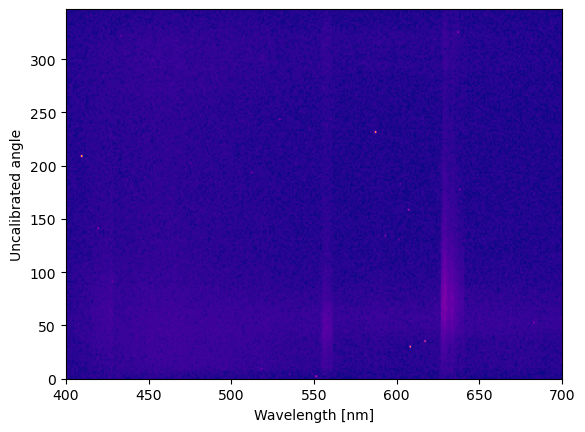

In [5]:
# Example of a spectral image from MISS-1
filename = os.path.join('Example files','MISS-20240211-055000.pgm')
spectralimage = read_miss_spectral(filename)

fig, ax = plt.subplots()
ax.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',
          extent=[400,700, 0, 347])
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Uncalibrated angle');

In [6]:
def find_auroral_emission_lines(roi_data):

    """
    Input is the square root of a spectral image as plotted above.
    A range of rows can be excluded from the spectralimage. The remainder is the region of interest or roi.

    First calculates the mean of every column. 
    Identifies peaks with the scipy find_peaks function based on a minimum prominence and width.
    Checks whether the three auroral emission lines are detected. 

    Output Boolean value. True when ALL three auroral emission lines are detected.
    """
    
    # Calculate the column-wise mean within the ROI
    col_means = np.mean(roi_data, axis=0)

    # Use scipy.signal.find_peaks to identify peaks
    global_peaks_col, properties = find_peaks(
        col_means,
        prominence=1.5,  # Minimum prominence of peaks
        width=2          # Minimum width of peaks
    )
    
    # Check whether auroral emission lines are clear
    condition_aurora_blue = any(25 <= num <= 35 for num in global_peaks_col)      # 425 - 435 nm
    condition_aurora_green = any(155 <= num <= 165 for num in global_peaks_col)   # 555 - 565 nm
    condition_aurora_red = any(225 <= num <= 235 for num in global_peaks_col)     # 625 - 635 nm

    check = condition_aurora_blue and condition_aurora_green and condition_aurora_red
    
    return check

In [7]:
def find_continuum_line_save(roi_data, lower_limit, filename, file):   

    """
    Input again is the region of interest from the square root of a spectral image. 

    Calculates the mean of every row.
    Identifies peaks in the row-wise mean with the scipy find_peaks function based on a minimum prominence and width.

    NOTE: 
    - The index of a detected peak is dependent on the input roi. 
    - Compensate the index with the lower limit of the roi for later analysis in the full spectral image (see example).
    - THE PROMINENCE OF PEAKS CHANGES WHEN A DIFFERENT ROI IS CHOSEN!!
    - It is advised to always use the same roi and optimize the parameters based on this roi!

    If at least one peak is detected this is saved in a notepad file.
    The first column includes the .pgm filename and the second column the peak indeces.
    """
    
    # Calculate the row-wise mean within the ROI
    row_means = np.mean(roi_data, axis=1)

    # Use scipy.signal.find_peaks to identify peaks
    peaks, properties = find_peaks(
        row_means,
        prominence=1.5,  # Minimum prominence of peaks
        width=4          # Minimum width of peaks
    )

    # Adjust peak indices to global row indices
    global_peaks = peaks + lower_limit

    # Remove peaks identified at index 42 (error in detector)
    filtered_peaks = np.delete(global_peaks, np.where(global_peaks==42))

    # Output the detected peaks
    if len(filtered_peaks) > 0:
        file.write(f"{filename}\t{filtered_peaks}\n")

## Example of defined functions

In [8]:
# Use the spectral image shown for example previously
# For the roi the rows between 30 and 180 have been used to exclude the sun on the horizon
roi_data = np.sqrt(spectralimage)[30:180]

# Calculate the column-wise mean within the ROI
col_means = np.mean(roi_data, axis=0)

# Use scipy.signal.find_peaks to identify peaks
global_peaks_col, properties = find_peaks(
    col_means,
    prominence=1.5,  # Minimum prominence of peaks
    width=2          # Minimum width of peaks
)

# In the output it can be seen that the three auroral emission lines are detected
# An additional peak is detected at index 62
global_peaks_col

array([ 27,  62, 157, 229], dtype=int64)

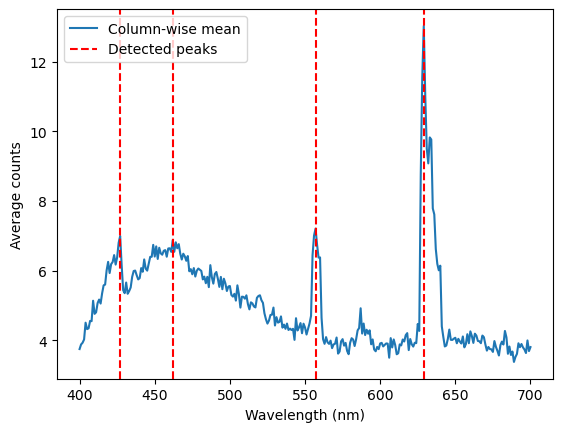

In [9]:
"""
The additional peak detected at index 62 is an example of a blue daylight spectrum. 
This is seen regularly as a parabolic spectrum centered around roughly 460 nm.
"""

# Plot column-wise mean
plt.plot(np.linspace(400,700,301), col_means)

# Plot detected peaks
for peak in global_peaks_col:
    plt.axvline(x = peak + 400, color='r', linestyle='dashed')
plt.legend(("Column-wise mean", "Detected peaks"), loc=2)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Average counts");

In [10]:
# Now we want to detect continuum emission
# Continue with the same example

# Calculate the row-wise mean within the ROI
row_means = np.mean(roi_data, axis=1)

# Use scipy.signal.find_peaks to identify peaks
peaks, properties = find_peaks(
    row_means,
    prominence=1.5,  # Minimum prominence of peaks
    width=4          # Minimum width of peaks
)

# Since we used a ROI we should compensate the found indeces
lower_limit = 30

# Adjust peak indices to global row indices
global_peaks = peaks + lower_limit
global_peaks

array([167], dtype=int64)

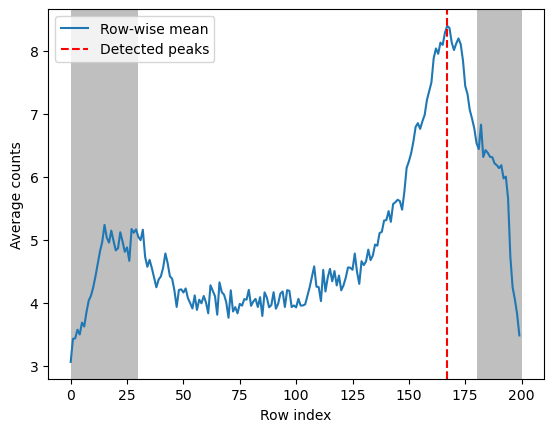

In [11]:
"""
It is visible in the gray shaded region that the number of counts drops off at the edges of the measurement.
This is an artifact of the measurement and is excluded as it can disrupt the peak finding function.
It is also possible that the sun is visible in these regions, resulting in a high number of counts which obscure the spectrum of auroras.
"""

# Plot row-wise mean of the ENTIRE spectral image
plt.plot(np.mean(np.sqrt(spectralimage), axis=1))

# Plot detected peaks
for peak in global_peaks:
    plt.axvline(x = peak, color='r', linestyle='dashed')

# Rows excluded in the ROI
plt.axvspan(0, 30, facecolor='gray', alpha=0.5)
plt.axvspan(180, 200, facecolor='gray', alpha=0.5)

plt.legend(("Row-wise mean", "Detected peaks"), loc=2)
plt.xlabel("Row index")
plt.ylabel("Average counts");

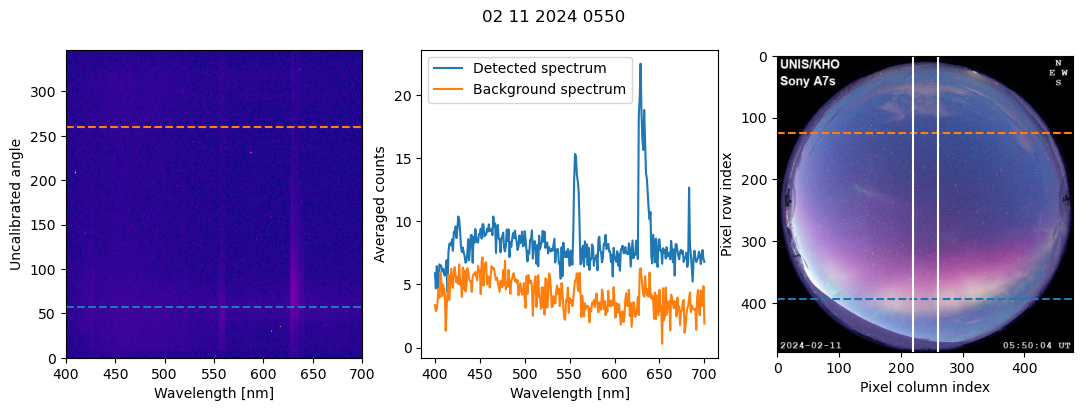

In [12]:
"""
This figure is a sneak peak of further analysis conducted in the MISS-1 post-detection analysis script.
The blue dashed line in the spectral image highlights where the functions above have detected a peak in the row-wise mean.
In the middle plot the corresponding spectrum is shown, averaged over a few rows to reduce noise.
A background spectrum is added for comparison, which shows the spectral enhancement over the entire wavelength range that resulted in a peak in the 
row-wise mean.
From the Sony all-sky camera image it is clear that the detected spectrum corresponds to a region of white auroral continuum emission.
"""

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

# Plot the spectral image
ax1.imshow(np.sqrt(spectralimage),cmap='plasma', aspect='auto',extent=[400,700, 0, 347])
# Highlight the peak detected at index 167 with a blue dashed line
ax1.axhline(y=347-(347/200)*167, color='C0', linestyle='dashed')
# Highlight the peak at index 50 with a orange dashed line
# This row is chosen as the background spectrum, ideally this consists of a clear sky
ax1.axhline(y=347-(347/200)*50, color='C1', linestyle='dashed')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Uncalibrated angle')

# To reduce noise we average a range of rows to produce the emission spectra for the detected row and the background
# The spectra are plotted in blue and orange, respectively
ax2.plot(np.linspace(400,700,301), np.mean(np.sqrt(spectralimage)[165:170,:],axis=0), color='C0')
ax2.plot(np.linspace(400,700,301), np.mean(np.sqrt(spectralimage)[48:53,:],axis=0), color='C1')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Averaged counts')
ax2.legend(("Detected spectrum","Background spectrum"))

# Plot an image of the Sony all-sky camera closest to the moment the spectral image was taken
image = plt.imread(os.path.join('Example files','LYR-Sony-20240211_055004.jpg'))
ax3.imshow(image)
# Highlight where the 'interesting' spectrum was detected and the background spectrum is taken with dashed lines in their respective colors
ax3.axhline(y = ((480-20)/200)*167+10, color = 'C0', linestyle = 'dashed')
ax3.axhline(y = ((480-20)/200)*50+10, color = 'C1', linestyle = 'dashed')
ax3.set_xlabel('Pixel column index')
ax3.set_ylabel('Pixel row index')

# In the center between the white lines is the meridian of the spectrograph where the spectral image is taken
ax3.axvline(x = 480/2-20, color = 'white')
ax3.axvline(x = 480/2+20, color = 'white')

fig.suptitle("02 11 2024 0550");

## Applying this script to a dataset

In [ ]:
"""
An example of a loop used to go over the MISS-1 data from the KHO observatory.

The MISS-1 data is sorted in subfolders based on year, month and day. 
MISS-1 has a time resolution of 1 minute, hence .pgm files have a YYYYMMDD-HHMMSS format in the filename (for example MISS-20240211-055000.pgm).
As there is a .pgm file for every minute this can quickly result in a lot of data. 
The loop can easily be modified to go only over a single day, a single month or (if you like to hurt your trusted laptop) all years of data.

In the current loop there is an output text file for each day of MISS-1 data, where the .pgm filename and row indeces of detected peaks are stored.

NOTE 
- This output method was chosen to store the data locally such that this script only has to be run a single time, as it can take days to go over all 
    MISS-1 data!
- The auroral emission line detection function is run first and skips the file if not all three emission lines are detected to reduce computation time,
    it is interesting to remove the condition of the blue auroral emission line as this one is often weaker and might simply not be detected. This is 
    implemented for the MISS-2 continuum detection. But, it can also result in more false positives.
"""

# Define the region of interest
lower_limit = 30  # Ignore rows below this
upper_limit = 180  # Ignore rows above this

year = ****
for month in os.listdir(os.path.join(your_data_directory,'MISS-1',year)):

    for day in os.listdir(os.path.join(your_data_directory,'MISS-1',year,month)):

        # Create output text file for every day
        output_file = f"your_output_directory\\{year}\\{month}\\MISS1_{year}_{month}_{day}.txt"
        with open(output_file, "a") as file: # 'a' mode appends instead of overwriting

            for filename in os.listdir(os.path.join(your_data_directory,'MISS-1',year,month,folder)):
                missFile=os.path.join(your_data_directory,'MISS-1',year,month,folder,filename)

                try:
                    spectralimage = read_miss_spectral(missFile)
    
                    # Restrict analysis to the region of interest
                    roi_data = np.sqrt(spectralimage)[lower_limit:upper_limit, :]
                    
                    # Only proceed with the further analysis if auroral emission lines are detected
                    # Reduces computation time
                    if find_auroral_emission_lines(roi_data):
                        pass
                    else:
                        continue   
                    find_continuum_line_save(roi_data, lower_limit, filename, file)
                # Sometimes a .pgm file can be corrupted and abort the enire loop, this prevents that
                # The filename is printed for possible manual analysis in the future
                except:
                    print(f"{filename} is corrupted")